In [51]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import dlib
import cv2
import os
import imutils
import lightgbm as lgb



OSError: dlopen(/Users/pingli/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: '/usr/local/opt/libomp/lib/libomp.dylib'
  Referenced from: '/Users/pingli/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so'
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [ ]:
faceCascade = cv2.CascadeClassifier("/Users/pingli/Desktop/DM+ML Project/001.Ping.Code/haarcascade_frontalface_default.xml")  
predictor = dlib.shape_predictor("/Users/pingli/Desktop/DM+ML Project/001.Ping.Code/shape_predictor_68_face_landmarks.dat")  

## 1. Preprocessing CSV file

In [ ]:
# Load training set
train = pd.read_csv('train.csv')
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
# Load whole dataset
whole = pd.read_csv('icml_face_data.csv')
whole.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
# Extract testing set
test = pd.concat([whole[whole[' Usage'] == 'PublicTest'], whole[whole[' Usage'] == 'PrivateTest']])
test = test.drop(columns=[' Usage'])
test = test.rename(columns = {' pixels':'pixels'})
test.head()

,emotion,pixels
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [ ]:
# Convert pixels to a matrix
def str_mat(data):
    pixels = data.loc[:, "pixels"]
    matrix = np.empty([pixels.shape[0], 2304])
    for i in data.index:
        one_sample = np.array([int(p) for p in pixels[i].split()])
        matrix[i-data.index[0]] = one_sample
    return matrix

In [ ]:
Xtr = str_mat(train)
ytr = train.loc[:, "emotion"]
print(Xtr.shape, ytr.shape)

(28709, 2304) (28709,)


In [ ]:
Xte = str_mat(test)
yte = test.loc[:, "emotion"]
print(Xte.shape, yte.shape)

(7178, 2304) (7178,)


### cf) to Image

In [ ]:
# # pixels to image
# def pix_img(idx, matrix):
#     face = matrix[idx].reshape(48,48)
#     plt.imshow(face)

In [ ]:
# pix_img(1, X)

### cf) Simple Face Detection with HoG

In [ ]:
# #step1: read the image
# image = cv2.imread("test_image.jpg")

# #step2: converts to gray image
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# #step3: get HOG face detector and faces
# hogFaceDetector = dlib.get_frontal_face_detector()
# faces = hogFaceDetector(gray, 1)

# #step4: loop through each face and draw a rect around it
# for (i, rect) in enumerate(faces):
#     x = rect.left()
#     y = rect.top()
#     w = rect.right() - x
#     h = rect.bottom() - y
#     #draw a rectangle
#     cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
# #step5: display the resulted image
# cv2.imshow("Image", image)
# cv2.waitKey(0); 
# cv2.destroyAllWindows(); 
# cv2.waitKey(1)

### cf) Feature Detection and Extraction

In [ ]:
# # Read the image  
# # image = cv2.imread("IMG_4733 Medium.jpeg")
# image = cv2.imread("test_image.jpg")
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
# # Detect faces in the image  
# faces = faceCascade.detectMultiScale(  
#   gray,  
#   scaleFactor=1.05,  
#   minNeighbors=5,  
#   minSize=(10, 10),  
#   flags=cv2.CASCADE_SCALE_IMAGE  
# )  

# print("Found {0} faces!".format(len(faces)))  

#### - Detect selected features

In [ ]:
# # Group each features
# JAWLINE_POINTS = list(range(0, 17))  
# RIGHT_EYEBROW_POINTS = list(range(17, 22))  
# LEFT_EYEBROW_POINTS = list(range(22, 27))  
# NOSE_POINTS = list(range(27, 36))  
# RIGHT_EYE_POINTS = list(range(36, 42))  
# LEFT_EYE_POINTS = list(range(42, 48))  
# MOUTH_OUTLINE_POINTS = list(range(48, 61))  
# MOUTH_INNER_POINTS = list(range(61, 68))  

In [ ]:
# # Draw a rectangle around the faces  
# for (x, y, w, h) in faces:  
#     cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  
#     # Converting the OpenCV rectangle coordinates to Dlib rectangle  
#     dlib_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))  

#     landmarks = np.matrix([[p.x, p.y] for p in predictor(image, dlib_rect).parts()])  
#     # Select area
#     landmarks_display = landmarks[RIGHT_EYE_POINTS + LEFT_EYE_POINTS]  

#     for idx, point in enumerate(landmarks_display):  
#         pos = (point[0, 0], point[0, 1])  
#         selected_image = cv2.circle(image, pos, 2, color=(0, 255, 255), thickness=-1)  

# cv2.imshow("Selected features", image)  
# cv2.waitKey(0)  
# cv2.destroyAllWindows(); 
# cv2.waitKey(1)

#### - Detect all features

In [ ]:
# # Draw a rectangle around the faces  
# for (x, y, w, h) in faces:  
#   cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  
  
#   # Converting the OpenCV rectangle coordinates to Dlib rectangle  
#   dlib_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))  
  
#   landmarks = np.matrix([[p.x, p.y]  
#               for p in predictor(image, dlib_rect).parts()])  
  
#   for idx, point in enumerate(landmarks):  
#     pos = (point[0, 0], point[0, 1])  
#     cv2.putText(image, str(idx), pos,  
#           fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,  
#           fontScale=0.4ƒ,  
#           color=(0, 0, 255))  
  
#     cv2.circle(image, pos, 2, color=(0, 255, 255), thickness=-1)  
  
# cv2.imshow("Landmarks found", image)  
# cv2.waitKey(0); 
# cv2.destroyAllWindows(); 
# cv2.waitKey(1)

## 2. Feature Matrix

#### - Helper functions

In [ ]:
def save_temp(idx, matrix):
    # face = matrix[idx].reshape(48,48)
    # plt.imsave("temp"+str(idx)+".jpg", face)

    cv2.imwrite("temp"+str(idx)+".jpg", np.reshape(matrix[idx], (48,48)))
    image = cv2.imread("temp"+str(idx)+".jpg")
    image = imutils.resize(image, width=500)

def delete_temp(img_name):
    os.remove(img_name)

def feature_vec(my_image, my_faces):
    my_landmarks = []
    for (x, y, w, h) in my_faces:  
        cv2.rectangle(my_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  
        # Converting the OpenCV rectangle coordinates to Dlib rectangle  
        dlib_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))  
        my_landmarks = np.matrix([[p.x, p.y] for p in predictor(my_image, dlib_rect).parts()])  
    return my_landmarks

#### - Convert Xtr into a featrue matrix

In [ ]:
# Initialize
Xtr_features = np.zeros((Xtr.shape[0], 68*2))
face_detected_tr = []
face_not_detected_tr = []

for i in range(Xtr.shape[0]):
    # Save image
    save_temp(i, Xtr)

    # Read the image  
    temp_image = cv2.imread("temp"+str(i)+".jpg")
    # temp_gray = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image  
    temp_faces = faceCascade.detectMultiScale(  
    temp_image,  
    scaleFactor=1.05,  
    minNeighbors=4,  
    minSize=(10, 10),  
    flags=cv2.CASCADE_SCALE_IMAGE)
    # print("Found {0} faces!".format(len(temp_faces)))  

    # # Show detected face
    # for (x, y, w, h) in temp_faces:
    #     cv2.rectangle(temp_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    # cv2.imshow('Window Title', temp_image)
    # cv2.waitKey(0); 
    # cv2.destroyAllWindows(); 
    # cv2.waitKey(1)

    # Get landmarks
    if len(temp_faces) > 0:
        # Get landmarks
        landmarks = np.array(feature_vec(temp_image, temp_faces))
        face_detected_tr.append(i)
    else:
        landmarks = np.zeros((1, 136))
        face_not_detected_tr.append(i)

    # Store landmarks
    Xtr_features[i] = landmarks.flatten()

    # Delete image
    delete_temp("temp"+str(i)+".jpg")

print(len(face_detected_tr), "faces detected, ", len(face_not_detected_tr), "faces not detected.")

13607 faces detected,  15102 faces not detected.


#### - Drop face non-detected data

In [ ]:
Xtr_features = Xtr_features[face_detected_tr]
ytr = np.array(ytr)
ytr = ytr[face_detected_tr]

#### - Convert Xte into a featrue matrix

In [ ]:
# Initialize
Xte_features = np.zeros((Xte.shape[0], 68*2))
face_detected_te = []
face_not_detected_te = []

for i in range(Xte.shape[0]):
    # Save image
    save_temp(i, Xte)

    # Read the image  
    temp_image = cv2.imread("temp"+str(i)+".jpg")
    # temp_gray = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image  
    temp_faces = faceCascade.detectMultiScale(  
    temp_image,  
    scaleFactor=1.05,  
    minNeighbors=4,  
    minSize=(10, 10),  
    flags=cv2.CASCADE_SCALE_IMAGE)

    # Get landmarks
    if len(temp_faces) > 0:
        # Get landmarks
        landmarks = np.array(feature_vec(temp_image, temp_faces))
        face_detected_te.append(i)
    else:
        landmarks = np.zeros((1, 136))
        face_not_detected_te.append(i)

    # Store landmarks
    Xte_features[i] = landmarks.flatten()

    # Delete image
    delete_temp("temp"+str(i)+".jpg")

print(len(face_detected_te), "faces detected, ", len(face_not_detected_te), "faces not detected.")

3433 faces detected,  3745 faces not detected.


#### - Drop face non-detected data

In [ ]:
Xte_features = Xte_features[face_detected_te]
yte = np.array(yte)
yte = yte[face_detected_te]

## 3. Distance Matrix

#### - Helper functions

In [ ]:
# Dawson's landmarks[a][b] = Here feature_matrix[2*a+b]
def feature_distance(feature_matrix):
    distance_matrix = np.zeros((feature_matrix.shape[0], 18))
    for i in range(feature_matrix.shape[0]):
        distances = []
        # right_eye_height
        distances.append(feature_matrix[i][83] - feature_matrix[i][75] + feature_matrix[i][81] - feature_matrix[i][77])
        # left_eye_height
        distances.append(feature_matrix[i][95] - feature_matrix[i][87] + feature_matrix[i][93] - feature_matrix[i][89])
        # right_eye_width
        distances.append(feature_matrix[i][78] - feature_matrix[i][72])
        # left_eye_width
        distances.append(feature_matrix[i][90] - feature_matrix[i][84])
        # left_eyebrow_width
        distances.append(feature_matrix[i][42] - feature_matrix[i][34])
        # right_eyebrow_width
        distances.append(feature_matrix[i][52] - feature_matrix[i][44])
        # right_eyebrow_eye_distance
        distances.append((feature_matrix[i][75] - feature_matrix[i][39] + feature_matrix[i][77] - feature_matrix[i][41]) / 2)
        # left_eyebrow_eye_distance
        distances.append((feature_matrix[i][87] - feature_matrix[i][47] + feature_matrix[i][89] - feature_matrix[i][49]) / 2)
        # mouth_gap
        distances.append((feature_matrix[i][135] + feature_matrix[i][133] + feature_matrix[i][131] - feature_matrix[i][125] - feature_matrix[i][123] - feature_matrix[i][127])/3)
        # mouth_height_center_avg
        distances.append((feature_matrix[i][117] + feature_matrix[i][115] + feature_matrix[i][113] - feature_matrix[i][101] - feature_matrix[i][103] - feature_matrix[i][105])/3)
        # mouth_height_left_avg
        distances.append((feature_matrix[i][119] + feature_matrix[i][117] + feature_matrix[i][115] - feature_matrix[i][99] - feature_matrix[i][101] - feature_matrix[i][103])/3)
        # mouth_height_right_avg
        distances.append((feature_matrix[i][115] + feature_matrix[i][113] + feature_matrix[i][111] - feature_matrix[i][103] - feature_matrix[i][105] - feature_matrix[i][107])/3)
        # mouth_height_centerline_toplip
        distances.append((feature_matrix[i][97] + feature_matrix[i][109])/2 - feature_matrix[i][103])
        # mouth_height_centerline_bottomlip
        distances.append(feature_matrix[i][115] - (feature_matrix[i][97] + feature_matrix[i][109])/2)
        # lip_width
        distances.append(feature_matrix[i][108] - feature_matrix[i][96])
        # distance_between_nose_toplip
        distances.append(feature_matrix[i][103] - feature_matrix[i][67])
        # distance_between_left_eye_corner_left_lip_corner
        lell = np.array([feature_matrix[i][96] - feature_matrix[i][72], feature_matrix[i][97] - feature_matrix[i][73]])
        distances.append((lell[0]**2 + lell[1]**2)**(1/2))
        # distance_between_right_eye_corner_right_lip_corner
        rerl = np.array([feature_matrix[i][90] - feature_matrix[i][108], feature_matrix[i][109] - feature_matrix[i][91]])
        distances.append((rerl[0]**2 + rerl[1]**2)**(1/2))
        # Add to the matrix
        distance_matrix[i] = np.array(distances)
    return distance_matrix

#### - Drop face non-detected data

In [ ]:
Xtr_distances = feature_distance(Xtr_features)
Xte_distances = feature_distance(Xte_features)

## UPDATE: Confidence Score

In [53]:
emotion_labels = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

In [75]:
def find_confidence_score(method,data):
    confidence_scores = method.predict_proba(data)
    confidence_list = []
    for i in range(len(confidence_scores)):
        confidence_list.append(max(confidence_scores[i]))
        confidence_scores[i]
        max_index = np.argmax(confidence_scores[i])
        emotion_label = emotion_labels.get(max_index, "Unknown") 
        print(confidence_list[i],emotion_label,max_index)
    
    
    return confidence_list
        

In [79]:
confidence_list = find_confidence_score(randomForest,Xte_features)

0.3051787307992906 Happy 3
0.6853408526091043 Happy 3
0.44136683787542685 Happy 3
0.21467941128979562 Neutral 6
0.27059177814951346 Neutral 6
0.29461937928302406 Neutral 6
0.21203201214271128 Neutral 6
0.28982686832772464 Neutral 6
0.22938484939210824 Neutral 6
0.2552090603555146 Neutral 6
0.35653577469197223 Happy 3
0.3810716095990886 Surprise 5
0.23223750128202 Happy 3
0.31718224959868135 Neutral 6
0.29214156022280746 Neutral 6
0.24716166511917328 Neutral 6
0.32377027353843874 Neutral 6
0.41306052779990327 Happy 3
0.26955229893773036 Neutral 6
0.41590889841682893 Happy 3
0.28104155805122377 Neutral 6
0.2680693949823853 Neutral 6
0.2267663780380408 Happy 3
0.2847475946705555 Neutral 6
0.4608017357514791 Happy 3
0.5911092603426885 Happy 3
0.26172517190717004 Neutral 6
0.6149172399653421 Happy 3
0.26323048536037286 Neutral 6
0.20857128081751963 Neutral 6
0.30403527091212945 Happy 3
0.22501220193356405 Neutral 6
0.2735052893137083 Neutral 6
0.2736450313784988 Neutral 6
0.2444026527899973

In [92]:
def find_top5_confident(confidence_list):
    print('Top 5 confidence scores and its image index:\n')
    max_values = sorted(confidence_list, reverse=True)[:5]
    for value in max_values:
        index = confidence_list.index(value)
        print(f"image #{index} with confidence score of {value}")
        
find_top5_confident(confidence_list)

Top 5 confidence scores and its image index:

image #1144 with confidence score of 0.8017851862642434
image #2765 with confidence score of 0.7982258226513061
image #1265 with confidence score of 0.7972243430521175
image #731 with confidence score of 0.7937276980698053
image #850 with confidence score of 0.7924901287211243


## 4. LightGBM

### 1) Using raw coordinates

In [ ]:
lightGBM = lgb.LGBMClassifier(random_state=0)
lightGBM.fit(Xtr_features, ytr)
ypr_lgbm = lightGBM.predict(Xte_features)
# Check accuracy
print('LightGBM using raw coordinates: {0:0.4f}'.format(accuracy_score(yte, ypr_lgbm)))

NameError: name 'lgb' is not defined

## CONFIDENCE SCORE FOR LIGHTGBM

In [93]:
confidence_score = find_confidence_score(lightGBM, Xte_features)

NameError: name 'lightGBM' is not defined

In [94]:
find_top5_confident(confidence_score)

NameError: name 'confidence_score' is not defined

### 2) Using distances

In [ ]:
lightGBM2 = lgb.LGBMClassifier(random_state=0)
lightGBM2.fit(Xtr_distances, ytr)
ypr_lgbm2 = lightGBM2.predict(Xte_distances)
# Check accuracy
print('LightGBM using distances: {0:0.4f}'.format(accuracy_score(yte, ypr_lgbm2)))

LightGBM using distances: 0.5456


## CONFIDENCE SCORE FOR LIGHTGBM 2

In [ ]:
find_confidence_score(lightGBM2, Xte_distances)

## 5. Random Forest

### 1) Using raw coordinates

In [55]:
randomForest = RandomForestClassifier(max_depth=5, random_state=0)
randomForest.fit(Xtr_features, ytr)
ypr_rf = randomForest.predict(Xte_features)
# Check accuracy
print('RF using raw coordinates: {0:0.4f}'.format(accuracy_score(yte, ypr_rf)))

RF using raw coordinates: 0.4154


## CONFIDENCE SCORE FOR RANDOM FOREST

In [95]:
confidence_score = find_confidence_score(randomForest, Xte_features)

0.3051787307992906 Happy 3
0.6853408526091043 Happy 3
0.44136683787542685 Happy 3
0.21467941128979562 Neutral 6
0.27059177814951346 Neutral 6
0.29461937928302406 Neutral 6
0.21203201214271128 Neutral 6
0.28982686832772464 Neutral 6
0.22938484939210824 Neutral 6
0.2552090603555146 Neutral 6
0.35653577469197223 Happy 3
0.3810716095990886 Surprise 5
0.23223750128202 Happy 3
0.31718224959868135 Neutral 6
0.29214156022280746 Neutral 6
0.24716166511917328 Neutral 6
0.32377027353843874 Neutral 6
0.41306052779990327 Happy 3
0.26955229893773036 Neutral 6
0.41590889841682893 Happy 3
0.28104155805122377 Neutral 6
0.2680693949823853 Neutral 6
0.2267663780380408 Happy 3
0.2847475946705555 Neutral 6
0.4608017357514791 Happy 3
0.5911092603426885 Happy 3
0.26172517190717004 Neutral 6
0.6149172399653421 Happy 3
0.26323048536037286 Neutral 6
0.20857128081751963 Neutral 6
0.30403527091212945 Happy 3
0.22501220193356405 Neutral 6
0.2735052893137083 Neutral 6
0.2736450313784988 Neutral 6
0.2444026527899973

In [96]:
find_top5_confident(confidence_score)

Top 5 confidence scores and its image index:

image #1144 with confidence score of 0.8017851862642434
image #2765 with confidence score of 0.7982258226513061
image #1265 with confidence score of 0.7972243430521175
image #731 with confidence score of 0.7937276980698053
image #850 with confidence score of 0.7924901287211243


### 2) Using distances

In [41]:
randomForest2 = RandomForestClassifier(max_depth=5, random_state=0)
randomForest2.fit(Xtr_distances, ytr)
ypr_rf2 = randomForest2.predict(Xte_distances)
# Check accuracy
print('RF using distances: {0:0.4f}'.format(accuracy_score(yte, ypr_rf2)))

RF using distances: 0.4766


## CONFIDENCE SCORE FOR RANDOM FOREST 2

In [97]:
confidence_score = find_confidence_score(randomForest2, Xte_distances)

0.2967949210281773 Happy 3
0.8475554525446443 Happy 3
0.42993168592949943 Happy 3
0.2663396656625743 Neutral 6
0.3423310618210853 Neutral 6
0.35116951009079533 Neutral 6
0.2360654358215891 Angry 0
0.3417036455898836 Neutral 6
0.4538572246619659 Surprise 5
0.27150166811601684 Neutral 6
0.2812554439054345 Neutral 6
0.5728001097294122 Surprise 5
0.2276570208978653 Happy 3
0.250196110346802 Neutral 6
0.2859097303522897 Neutral 6
0.34384449356060437 Neutral 6
0.26430671740822254 Surprise 5
0.3260193065318968 Angry 0
0.3408614435721817 Neutral 6
0.4285127477129895 Happy 3
0.2902935392341703 Surprise 5
0.3148888781338319 Neutral 6
0.2842755195027523 Neutral 6
0.34139911028853925 Neutral 6
0.675799055339987 Happy 3
0.8070796714980343 Happy 3
0.4988156520043996 Surprise 5
0.8386313251797306 Happy 3
0.3538571878841805 Neutral 6
0.29167378096164936 Happy 3
0.4421975287219718 Surprise 5
0.27109947310504856 Neutral 6
0.2739005503806269 Neutral 6
0.34235843846452874 Neutral 6
0.231693851351753 Happy

In [98]:
find_top5_confident(confidence_score)

Top 5 confidence scores and its image index:

image #2037 with confidence score of 0.8501900604820706
image #2037 with confidence score of 0.8501900604820706
image #2037 with confidence score of 0.8501900604820706
image #2357 with confidence score of 0.8500920613096058
image #2243 with confidence score of 0.8491191853251537


## 6. AdaBoost

### 1) Using raw coordinates

In [44]:
from sklearn.ensemble import AdaBoostClassifier


In [45]:
adaBoost = AdaBoostClassifier(n_estimators=100, random_state=0)
adaBoost.fit(Xtr_features, ytr)
ypr_ada = adaBoost.predict(Xte_features)
# Check accuracy
print('AdaBoost using raw coordinates: {0:0.4f}'.format(accuracy_score(yte, ypr_ada)))

AdaBoost using raw coordinates: 0.4594


## CONFIDENCE SCORE FOR ADABOOST

In [99]:
confidence_score = find_confidence_score(adaBoost, Xte_features)

0.14394441962034335 Happy 3
0.14686676370326224 Happy 3
0.14560086596645463 Happy 3
0.14461247922368425 Happy 3
0.14740068856510052 Neutral 6
0.14605697945300825 Sad 4
0.14534277994576505 Fear 2
0.14613321511206478 Surprise 5
0.14601815773133942 Surprise 5
0.14636274643901778 Surprise 5
0.14551029636281465 Happy 3
0.14522980459342438 Neutral 6
0.15239092282913652 Angry 0
0.1482221399510998 Neutral 6
0.14515312554649165 Neutral 6
0.14415499093859546 Neutral 6
0.14732267325523515 Neutral 6
0.14642849055866647 Neutral 6
0.14522426020931004 Neutral 6
0.14747326041468317 Happy 3
0.1475577496858194 Neutral 6
0.14585548877003854 Neutral 6
0.14458914046586016 Angry 0
0.1462502182458945 Surprise 5
0.14737051846454566 Happy 3
0.1484841911506934 Happy 3
0.14752774904782137 Surprise 5
0.14802282771301403 Happy 3
0.14567876057181056 Neutral 6
0.14471109900544063 Angry 0
0.1493860538438282 Surprise 5
0.14452234585570048 Neutral 6
0.14534446253441055 Neutral 6
0.14528749627105544 Neutral 6
0.14411762

In [100]:
find_top5_confident(confidence_score)

Top 5 confidence scores and its image index:

image #1568 with confidence score of 0.20570425613791687
image #2107 with confidence score of 0.1833422356000649
image #356 with confidence score of 0.1748809724849709
image #581 with confidence score of 0.15819546940408277
image #2621 with confidence score of 0.15622182162468687


### 2) Using distances

In [48]:
adaBoost2 = AdaBoostClassifier(n_estimators=100, random_state=0)
adaBoost2.fit(Xtr_distances, ytr)
ypr_ada2 = adaBoost2.predict(Xte_distances)
# Check accuracy
print('AdaBoost using distances: {0:0.4f}'.format(accuracy_score(yte, ypr_ada2)))

AdaBoost using distances: 0.4873


## CONFIDENCE SCORE FOR ADABOOST 2

In [101]:
confidence_score = find_confidence_score(adaBoost2, Xte_distances)

0.1441307245864144 Happy 3
0.1520793976580429 Happy 3
0.14693152637388252 Happy 3
0.14473855539404457 Neutral 6
0.14677196928188396 Surprise 5
0.14535209948752587 Neutral 6
0.14679839267014325 Angry 0
0.1458561210859388 Neutral 6
0.14665105552995356 Surprise 5
0.14585722820812982 Surprise 5
0.14435178829626777 Neutral 6
0.14778205158481336 Surprise 5
0.14491358090704526 Angry 0
0.14513154371124945 Fear 2
0.14582036487460892 Neutral 6
0.14552137402440699 Neutral 6
0.14518822398471284 Surprise 5
0.14721553989506683 Angry 0
0.14562474919483873 Neutral 6
0.14803355672921545 Happy 3
0.1468052620954747 Surprise 5
0.14657605726927583 Neutral 6
0.14554693378824898 Angry 0
0.14721990066871457 Surprise 5
0.15562467626474102 Happy 3
0.15262844805822418 Happy 3
0.14763388928860122 Surprise 5
0.15018973505948827 Happy 3
0.14546993200534242 Neutral 6
0.1455081384595021 Sad 4
0.1532637405950011 Surprise 5
0.14445064123841422 Neutral 6
0.14426526266674397 Neutral 6
0.14560533503403436 Neutral 6
0.1452

In [102]:
find_top5_confident(confidence_score)

Top 5 confidence scores and its image index:

image #2143 with confidence score of 0.16735452483642477
image #646 with confidence score of 0.16592633337683751
image #1907 with confidence score of 0.16566161805104118
image #1685 with confidence score of 0.16558499308225932
image #2110 with confidence score of 0.16555197468172056


## 7. ROC curve

In [ ]:
# Binarize
def binarize(model, tr_features, te_features, y_tr, y_te):
    label_binarizer = LabelBinarizer().fit(y_tr)
    y_onehot_test = label_binarizer.transform(y_te)
    y_score = model.fit(tr_features, ytr).predict_proba(te_features)
    return y_onehot_test, y_score

# Plot ROC curve
def roc_curve(models, onehot_tests, scores):
    # plotting parameters
    cols = 3
    linewidth = 1
    rows = math.ceil(7 / cols)
    emotions = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}

    fig, axs = plt.subplots(rows, cols, figsize=(15, rows*6))
    model_names = {0:'LightGBM', 1:'RF', 2:'Ada'}

    for i in range(7):
        emotion_name = emotions[i]
        for m in range(len(models)):
            model_name = model_names[m]
            display = RocCurveDisplay.from_predictions(onehot_tests[m][:, i],
                                                       scores[m][:, i],
                                                       name=f"{model_name}",
                                                       linewidth=linewidth,
                                                       ax=axs[i // cols, i % cols],)

        axs[i // cols, i % cols].plot([0, 1], [0, 1], linewidth=linewidth, linestyle=":")
        axs[i // cols, i % cols].set_title(emotion_name)
        axs[i // cols, i % cols].set_xlabel("False Positive Rate")
        axs[i // cols, i % cols].set_ylabel("True Positive Rate")
    plt.tight_layout(pad=2.0)  # spacing between subplots
    plt.show()

### 1) Using raw coordinates

In [ ]:
gbm_oh, gbm_sc = binarize(lightGBM, Xtr_features, Xte_features, ytr, yte)
rf_oh, rf_sc = binarize(randomForest, Xtr_features, Xte_features, ytr, yte)
ada_oh, ada_sc = binarize(adaBoost, Xtr_features, Xte_features, ytr, yte)

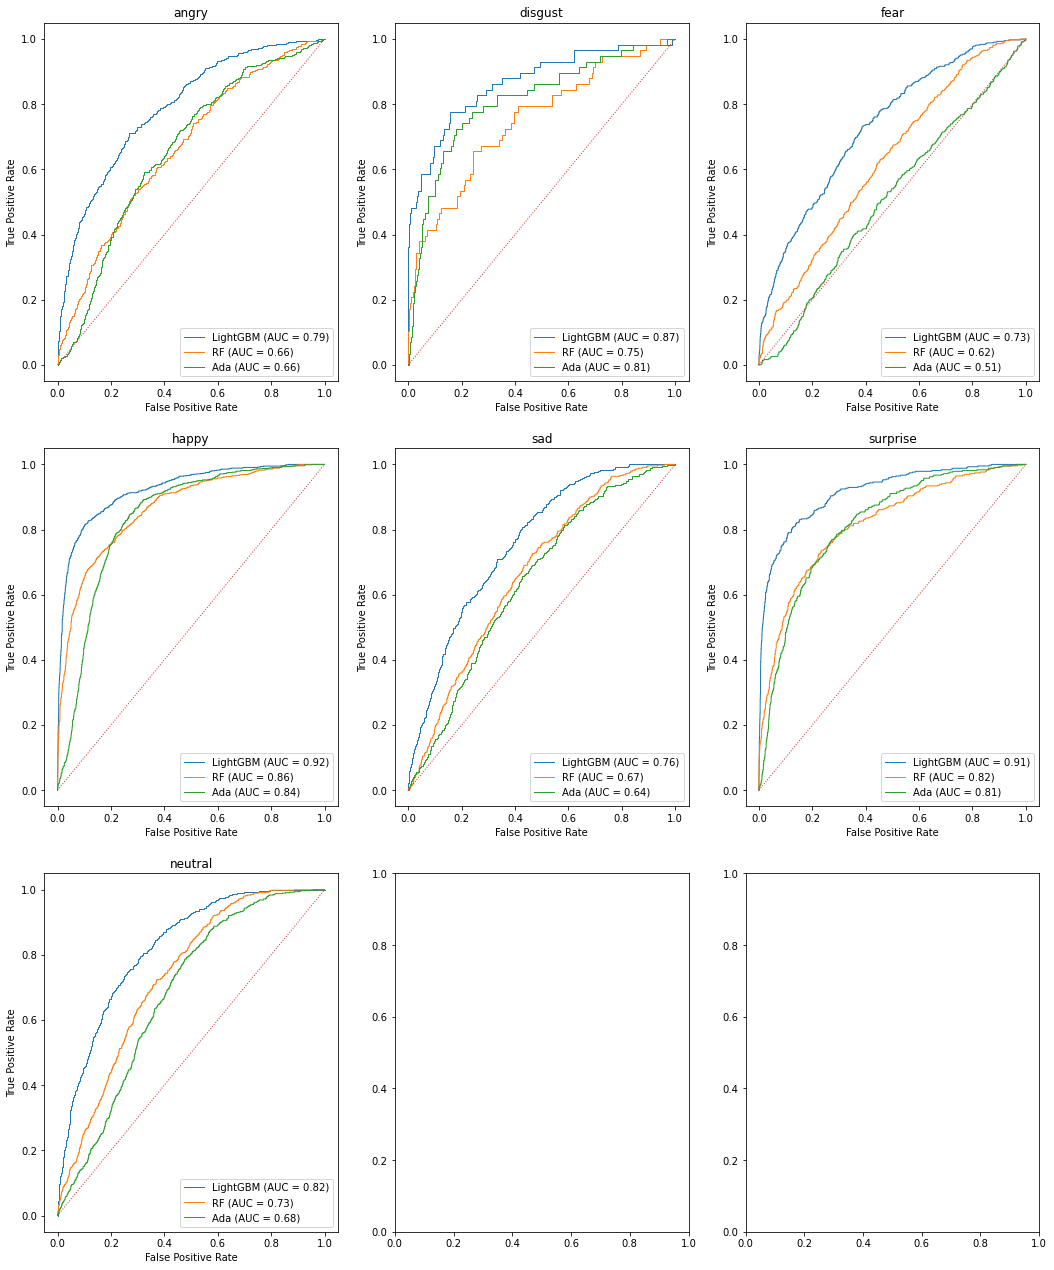

In [ ]:
roc_curve([lightGBM, randomForest, adaBoost], [gbm_oh, rf_oh, ada_oh], [gbm_sc, rf_sc, ada_sc])

### 2) Using distances

In [ ]:
gbm_oh2,gbm_sc2 = binarize(lightGBM2, Xtr_distances, Xte_distances, ytr, yte)
rf_oh2, rf_sc2 = binarize(randomForest2, Xtr_distances, Xte_distances, ytr, yte)
ada_oh2, ada_sc2 = binarize(adaBoost2, Xtr_distances, Xte_distances, ytr, yte)

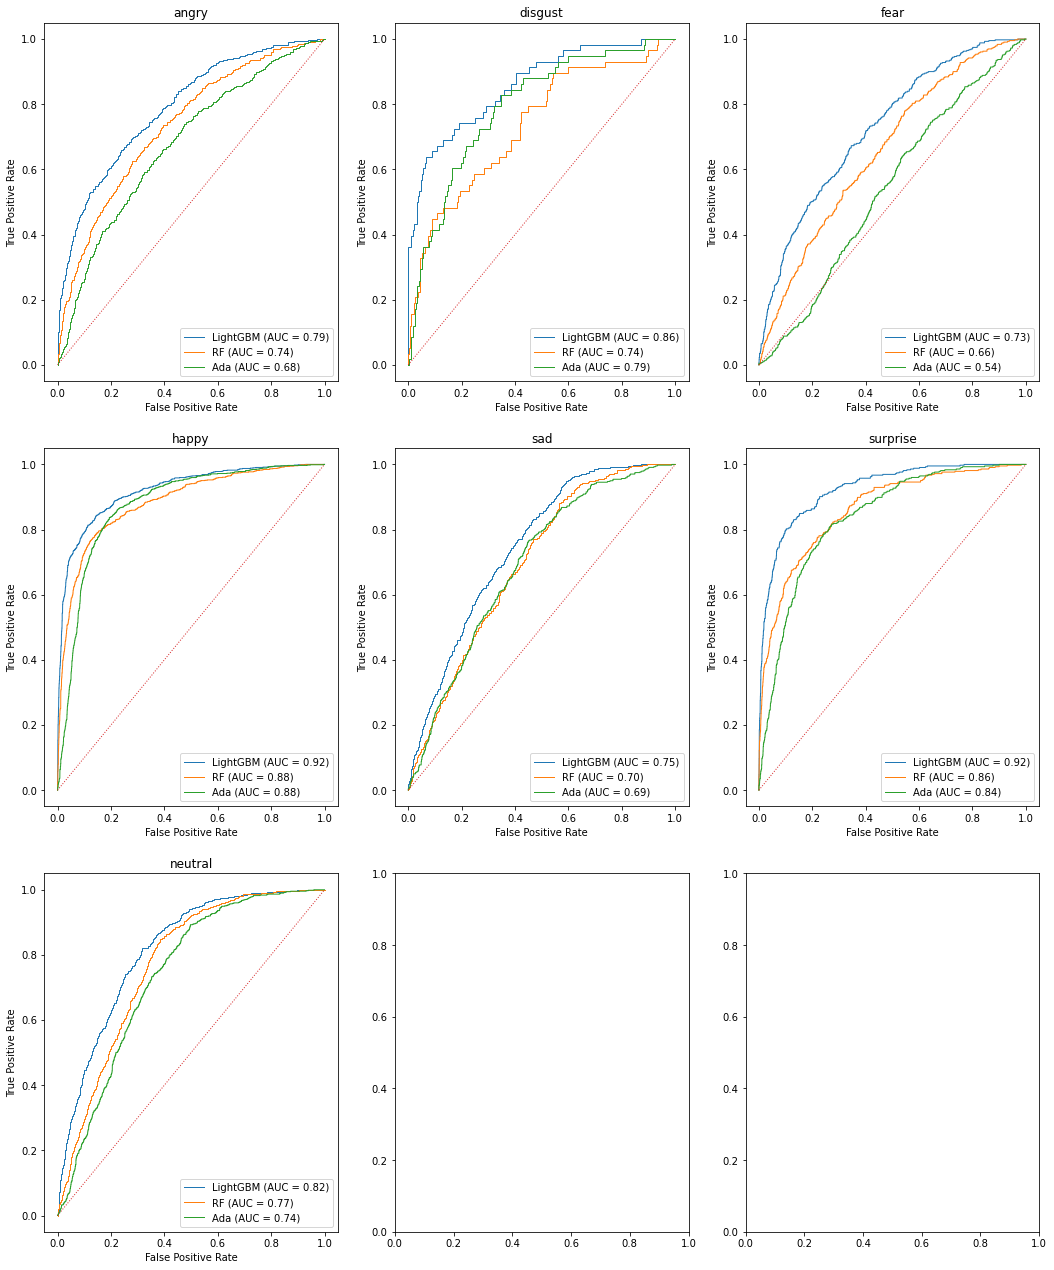

In [ ]:
roc_curve([lightGBM2, randomForest2, adaBoost2], [gbm_oh2, rf_oh2, ada_oh2], [gbm_sc2, rf_sc2, ada_sc2])